In [283]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers


import sys
from collections import Counter 
import pprint 
import math
import argparse 
import os
import collections
import json
import re
import numpy as np
import matplotlib.pyplot as plt 
import random
import time 
import pandas as pd
import itertools
import tensorflow as tf

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.set_random_seed(seed_value)
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

### Merge categories

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# funtions to handle labels
from utils.handle_labels import get_tag_counts_and_labels
from utils.handle_labels import drop_labels
from utils.handle_labels import group_labels
from utils.handle_labels import categories_count
from utils.handle_labels import get_imbalance
from utils.handle_labels import label_distribution
from utils.handle_labels import number_of_labels
#from utils.message_preprocess import message_processing
# plot untils funcion
from utils.plot_utils import pie_plot

(1922, 28)
<class 'list'>
['Testing', 'Bug fix']
Maintenance : 891
Feature Add : 330
Bug fix : 266
Documentation : 237
Clean up : 192
Refactoring : 111
Indentation : 48
Token Replace : 40
Source Control : 30
Cross : 24
Legal : 18
Debug : 10
Module Remove : 6
Module Move : 5
Rename : 5
Versioning : 4
Merge : 3
Initialization : 2
Data : 1
Module Add : 1
Internationalization : 1
1    1625
2     226
3      35
4       7
5       3
dtype: int64


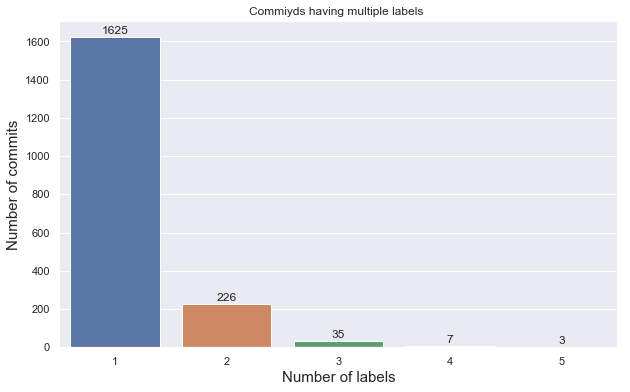

Other : 34
Implementation : 330
Perfective : 1093
Adaptive : 237
Corrective : 266
Non_functional : 70


In [315]:
df = pd.read_csv('data/commit_data_new.csv')
print(df.shape)

# convert string to list
from ast import literal_eval

df['categories'] = df['categories'].apply(lambda x: literal_eval(x))
print(type(df['categories'].values[0]))
print(df['categories'].values[0])
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

#tags_counts,target_columns = get_tag_counts_and_labels(df)
#print(target_columns)

# drop testing and build
new_df = drop_labels(df, ['Testing', 'Build'])
_ , target_col = get_tag_counts_and_labels(new_df)
multi_count = number_of_labels(new_df, target_col)

def group_labels_new(df, labels_to_group, new_label):
    '''
    Group some of labels

    Args:
        df - dataframe
        labels_to_group -  List of labels you want to group
        new_label -  string - new label name of grouped labels

    Returns:
        new_df - dataframe after grouped
    '''
    new_df = df.copy()

    # generate new labels by group labels
    def create_new_label(row, labels):
        new_label = 0  # initialize new label
        for label in labels:
            if row[label] == 1:
                new_label = 1  # if one of labels in grouped labels is 1 the new label is 1
        return new_label

    new_df[new_label] = df.apply(lambda row: create_new_label(row, labels_to_group), axis=1)

    # generate list of new_categories

    return new_df

new_df = group_labels_new(new_df, ['Bug fix'], 'Corrective')
new_df = group_labels_new(new_df, ['Documentation'], 'Adaptive')
new_df = group_labels_new(new_df, ['Clean up', 'Maintenance','Refactoring'], 'Perfective')
new_df = group_labels_new(new_df, ['Feature Add'], 'Implementation')
new_df = group_labels_new(new_df, ['Legal', 'Module Remove','Rename','Token Replace','Merge'], 'Non_functional')
new_df = group_labels_new(new_df, ['Cross','Debug'], 'Other')

target_col = ['Corrective','Adaptive','Perfective','Implementation','Non_functional','Other']
multi_count = categories_count(new_df, target_col)

In [316]:
# Drop 'Non-functional' and 'Other'

new_df = new_df.drop(['Non_functional','Other'],axis = 1)

target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = categories_count(new_df, target_col)

Adaptive : 237
Implementation : 330
Corrective : 266
Perfective : 1093


1    1616
2     136
0     132
3      10
4       2
dtype: int64


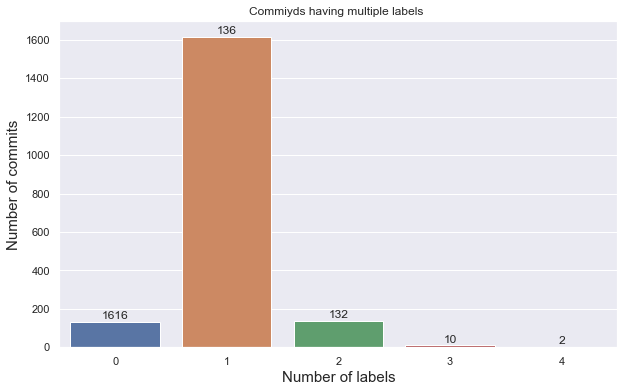

current number of samples: 1896
number of samples after drop:1616


In [317]:
# Drop rows with multiple labels
target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = number_of_labels(new_df, target_col)

print('current number of samples: %d'%new_df.shape[0])
new_df['label_sum'] = new_df[target_col].sum(axis=1)
new_df = new_df[new_df['label_sum']==1].reset_index(drop=True)
print('number of samples after drop:%d'%new_df.shape[0])
new_df = new_df.drop(['label_sum'], axis = 1)

In [318]:
# Drop target col
new_df = new_df[new_df['Corrective']!=1].reset_index(drop=True)
target_col = ['Adaptive','Perfective','Implementation']

In [319]:
csha = new_df['Commit ID'].values
files = [c + '.json' for c in csha]
application_name = new_df['project name'].values
files_path = []
for project_name, c in zip(application_name,files):
    files_path.append(project_name + '_' + c)
print(files_path[0])

apache-avro_2df0775d2f368b326e3ac6442ce4850e3fe62edc.json


In [320]:
def parse_json(filepath, files):
    """
    function used to parse json of each commit json file

    Args:
        filepath_list - list of filepaths

    Returns:
        files_json - list object contains parsed information

    """

    files_json = []
    commit_ids = []
    # each commits
    #files = os.listdir(filepath)
    for path in files:
        commit_id = path.split("_")[1].split(".")[0]
        try:
            if os.stat(filepath + path).st_size != 0 and path != 'desktop.ini':
                with open(filepath + path, encoding="utf8") as f:
                    data = json.load(f)
                    files_list = []
                    # each file in commits
                    for file in data['files']:
                        # parse only cluster file
                        for key in file.keys():
                            if re.match('^.*_cluster$', key):
                                actions_list = []
                                actions = file[key]['actions']
                                # each action in file
                                for action in actions:
                                    actions_list.append(action['root'])
                                files_list.append(actions_list)
                if len(files_list) != 0:
                    files_json.append(files_list)
                    commit_ids.append(commit_id)
        except FileNotFoundError as e: 
            continue 
    assert(len(commit_ids) == len(files_json))      
    # return
    return files_json, commit_ids

files = files_path
folder_path = 'C:\\Users\\ichel\\Desktop\\shared_ReFiles\\AllFiles_Research\\'
all_files, csha = parse_json(folder_path, files)

In [321]:
def preprocess_roots(files_data):
    counting = {}
    for file_index, files in enumerate(files_data):
        for root_index, roots in enumerate(files):
            for action_index, actions in enumerate(roots):
                temp = actions.split(' at ')[0].strip()
                tempq = []
                if temp.startswith('INS'):
                    tempq.append('INS')
                    words = [temp.split('INS ')[1].split('to ')[0].strip()] + [
                        temp.split('INS ')[1].rsplit('to ')[-1].strip()
                    ]
                    for items in words:
                        items = items.split(':')[0].strip()
                        tempq.append(items)
                    if tempq[1] == 'TextElement' and tempq[-1] not in ['TagElement', 'TextElement']:
                        tempq[-1] = ''
                    temp = '_'.join(tempq)

                if temp.startswith('UPDATE'):
                    temp = 'UPDATE'
                if temp.startswith('MOVE'):
                    temp2 = temp.split('from ')[1].strip()
                    tempq.append('MOVE')
                    tempq.append(temp2.split(':')[0].strip())
                    temp = '_'.join(tempq)

                if temp.startswith('DEL'):
                    tempq.append('DEL')
                    tempq.append(temp.split('DEL ')[1].split(':')[0].strip())
                    temp = '_'.join(tempq)
                temp = temp.replace(' ', '_')
                counting[temp] = counting.get(temp, 0) + 1
                files_data[file_index][root_index][action_index] = temp
    dic = {}
    i = 0
    for k, v in counting.items():
        dic[k] = i
        i += 1
    return dic, files_data, counting

In [322]:
dic, datas, freq_dict = preprocess_roots(all_files)
rev_dic = dict(zip(dic.values(), dic.keys()))
print(len(dic))

472


In [323]:
def actions2sentence(datas):
    data_total = []
    for files in datas:
        data4file = []
        for roots in files:
            sentence = ' '.join(roots)
            data4file.append(sentence)
        data_total.append(data4file)
    return data_total


training_data = actions2sentence(datas)

## Data Preperation: 
Prepare data for embedding and training .

In [324]:
from utils.handle_labels import drop_labels
from utils.handle_labels import group_labels
from ast import literal_eval

In [325]:
def permutate_files(csha, training_data): 
    commits_dic = dict()
    for sha, training_file in zip(csha, training_data): 
        commits_dic[sha] = []
        if len(training_file) <= 5: 
            tmp_permutate = list(itertools.permutations(training_file))
            for permutated_file in tmp_permutate: 
                commits_dic[sha].append(list(permutated_file))
        else: 
            commits_dic[sha].append(training_file)
    return commits_dic

In [326]:
def expand_list(commits_labels_df):
    s= commits_labels_df.apply(lambda x: pd.Series(x['Files']),axis=1).stack().reset_index(level=1, drop=True)
    s.name = "Files"
    commits_labels_df = commits_labels_df.drop("Files", axis=1) 
    commits_labels_df = commits_labels_df.join(s)
    return commits_labels_df

In [327]:
# merge csha and training data to a dataframe
commits_df = pd.DataFrame(data = [csha, training_data]).T
commits_df.columns = ["Commit ID", "Files"]
print(new_df.shape)

# merge two dataframe and drop some of labels
commits_labels_df = pd.merge(commits_df, new_df, on='Commit ID')

# split dataframe to train and test
msk = np.random.rand(len(commits_labels_df)) < 0.8
train_df = commits_labels_df[msk]
test_df = commits_labels_df[~msk]

# permutate train_df
permutate_train_dic = permutate_files(train_df['Commit ID'],train_df['Files'])
permutate_train_df = pd.DataFrame(list(permutate_train_dic.items()))
print(permutate_train_df.head())
permutate_train_df.columns = ['Commit ID','Files']
train_df = train_df.drop(["Files"], axis=1)
train_df['Files'] = permutate_train_df['Files'].values

# expanded train_df list
expanded_train_df = expand_list(train_df)

print('exp_train_df shape:',expanded_train_df.shape)
print('train_df shape:',train_df.shape)
print('test_df shape:',test_df.shape)

(1389, 29)
                                          0  \
0  120d1c7a8d96d9c81a92e6600e1c0e2c7cbdcb98   
1  7c9a32aa195f03ff21b977d9193306c752d1d084   
2  c32f465d442c52edb8aba4e7fb78c153639d8cd7   
3  95d65666c8a51011273ad0612023c74eb128007a   
4  4aa958d3a2d071762ec4ce51ea160a3eceff9b29   

                                                   1  
0  [[MOVE_VariableDeclarationFragment DEL_IfState...  
1          [[INS_MethodInvocation_MethodInvocation]]  
2  [[MOVE_CompilationUnit INS_ImportDeclaration_C...  
3                         [[UPDATE DEL_TextElement]]  
4  [[MOVE_CompilationUnit UPDATE UPDATE DEL_Field...  
exp_train_df shape: (8156, 30)
train_df shape: (940, 30)
test_df shape: (260, 30)


In [328]:
def concat_files_to_sentence(expanded_train_list): 
    concat_data = ""
    tmp_list = []
    for items in expanded_train_list:
        concat_data = " ".join(items)
        tmp_list.append(concat_data)
    return tmp_list
concat_train_data = concat_files_to_sentence(expanded_train_df["Files"])
concat_test_data = concat_files_to_sentence(test_df["Files"])
print(concat_train_data[0])
print("  ")
print(concat_test_data[0])

MOVE_VariableDeclarationFragment DEL_IfStatement INS_Block_MethodDeclaration MOVE_Block DEL_Block
  
INS_ImportDeclaration_CompilationUnit INS_ImportDeclaration_CompilationUnit INS_ImportDeclaration_CompilationUnit INS_TypeDeclaration_TypeDeclaration INS_TypeDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration INS_FieldDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration MOVE_TypeDeclaration MOVE_MethodDeclaration MOVE_MethodDeclaration MOVE_MethodDeclaration INS_Javadoc_MethodDeclaration UPDATE INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_Block_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration MOVE_FieldDeclaration INS_ParameterizedType_FieldDeclaration 

## Determine File Threshold 

<sample training data>:  ['INS_ImportDeclaration_CompilationUnit INS_ImportDeclaration_CompilationUnit INS_ImportDeclaration_CompilationUnit INS_TypeDeclaration_TypeDeclaration INS_TypeDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration INS_FieldDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration MOVE_TypeDeclaration MOVE_MethodDeclaration MOVE_MethodDeclaration MOVE_MethodDeclaration INS_Javadoc_MethodDeclaration UPDATE INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_Block_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration MOVE_FieldDeclaration INS_ParameterizedType_FieldDeclaration MOVE_FieldDeclaration MOVE_FieldDeclaration INS_SingleVariableDeclaration_

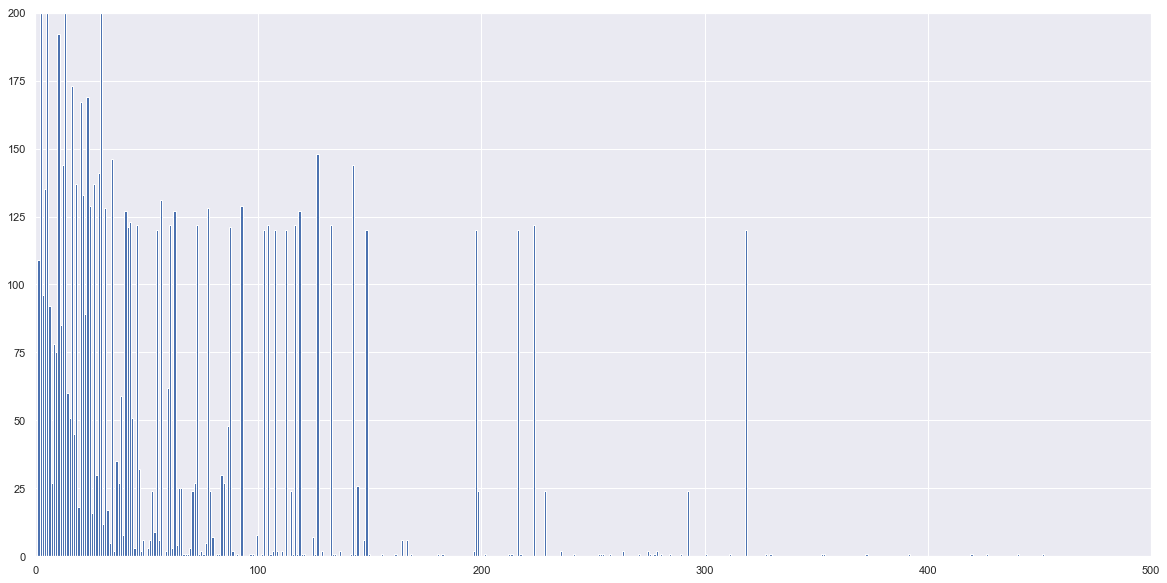

In [329]:
def get_seqlength(training_data):
    max_root_len = 0
    seqlength_list = []
    for item in training_data:
        seqlength_list.append(len(item.split()))
        if len(item.split()) >  max_root_len: 
            max_root_len = len(item.split())
    return max_root_len, seqlength_list

def plot_hist(seqlength_list): 
    plt.figure(figsize=(20,10))
    number_of_files = np.array(seqlength_list)
    bincount = np.bincount(seqlength_list)
    x = np.arange(1, len(bincount)+1)
    n, bins, patches = plt.hist(seqlength_list,x)
    plt.xlim((0, 500))
    plt.ylim((0, 200))

max_seqlength, sequence_list = get_seqlength(concat_train_data)
print("<sample training data>: ", training_data[0])
plot_hist(sequence_list)

In [330]:
# getting file threshold
threshold = 0.95
number_of_actions = [len(item.split()) for item in concat_train_data]

def get_file_threshold(number_of_files, threshold = 0.95):
    '''
    get padding threshold for files dimension
    
    Args:
        number_of_files - array of the number of files in each commits
        threshold - drop all commits with its the number of files beyond this threshold
    Returns:
        padding threshold - number
    '''
    
    total_files = len(number_of_files)
    number_of_files = np.array(number_of_files)
    bincount = np.bincount(number_of_files)

    sum_file = 0
    for index, item in enumerate(bincount):
        sum_file += item
        #print(index,item)
        #print(sum_file)
        if sum_file > threshold*total_files:
            padding_files_threshold = index
            break
            
    return padding_files_threshold

length_threshold = get_file_threshold(number_of_actions, threshold)
print(length_threshold)

216


## Prepare Labels

In [331]:
expanded_train_df = expanded_train_df.drop(["Files"], axis=1)
test_df = test_df.drop(["Files"], axis=1)
expanded_train_df["Files"] = concat_train_data 
test_df["Files"] = concat_test_data 

In [332]:
expanded_train_df['len_seq'] = expanded_train_df.apply(lambda row: len(row['Files'].split()), axis = 1)
test_df['len_seq'] = test_df.apply(lambda row: len(row['Files'].split()), axis = 1)
expanded_train_df = expanded_train_df[expanded_train_df['len_seq'] <= length_threshold].reset_index(drop = True)
test_df = test_df[test_df['len_seq'] <= length_threshold].reset_index(drop = True)
print(test_df.columns)

Index(['Commit ID', 'project name', 'commit_message', 'Maintenance',
       'Feature Add', 'Bug fix', 'Documentation', 'Clean up', 'Refactoring',
       'Indentation', 'Token Replace', 'Source Control', 'Cross', 'Legal',
       'Debug', 'Module Remove', 'Module Move', 'Rename', 'Versioning',
       'Merge', 'Initialization', 'Internationalization', 'Data', 'Module Add',
       'categories', 'Corrective', 'Adaptive', 'Perfective', 'Implementation',
       'Files', 'len_seq'],
      dtype='object')


In [333]:
target_col =  ['Adaptive','Perfective','Implementation']
y_train = expanded_train_df[target_col].values
y_test = test_df[target_col].values
print("traing labels shape: ", y_train.shape) 
print("test labels shape: ", y_test.shape)

traing labels shape:  (7818, 3)
test labels shape:  (247, 3)


## Tokenize and Pad data 
We tokenize the data and pad with the token <PAD/>.<br/> 

In [334]:
#Training 
train_docs = expanded_train_df['Files'].values
t_train = Tokenizer(filters = '', lower=False)
t_train.fit_on_texts(train_docs)

#Testing 
test_docs = test_df['Files'].values 
t_test = Tokenizer(filters = '', lower=False)
t_test.fit_on_texts(test_docs)

sequences_train = t_train.texts_to_sequences(train_docs)
sequences_test = t_test.texts_to_sequences(test_docs)
print(sequences_train[0])
print(sequences_test[0])

#Pad training data 
padded_seq_train = pad_sequences(sequences_train, maxlen=length_threshold + 1, padding="post", truncating="post")
print(padded_seq_train.shape)

#Pad testing data 
padded_seq_test = pad_sequences(sequences_test, maxlen=length_threshold + 1, padding="post", truncating="post")
print(padded_seq_test.shape)

[35, 33, 43, 9, 27]
[10, 10, 3, 220, 20, 6, 6, 76, 76, 140, 104, 12, 157, 1, 221, 11, 11, 1, 1, 1, 15, 10, 3, 20, 20, 23, 6, 15, 20, 20, 15, 1, 20, 20, 20, 23, 129, 35, 35, 11, 35, 20, 20, 11, 11, 11, 105, 105, 105, 158, 37, 141, 15, 26, 15, 1, 4, 4, 15, 27, 9, 9]
(7818, 217)
(247, 217)


## Creating Testing and Training Set 

In [335]:
vocabulary_train = t_train.word_index
vocabulary_test = t_test.word_index 


vocabulary_inv_train = dict((v, k) for k, v in vocabulary_train.items())
vocabulary_inv_test = dict((v, k) for k, v in vocabulary_test.items())
vocabulary_inv_train[0] = "<PAD/>"
vocabulary_inv_test[0] = "<PAD/>"

In [336]:
X_train = padded_seq_train 
X_test = padded_seq_test
print(X_train[10, :])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

[84  1 16 34  3  3  3  3 59 59 59 59 84  1 16 34  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
(7818, 217)
(247, 217)
(7818, 3)
(247, 3)


### Embedding

In [337]:
def load_embedding(filename):
    """
    load embedding as python dictionary {root<str>: embeddings<np_array>}
    :param filename: embedding.txt 
    :return: dictionary object mapping root to embeddings 
    """
    if not os.path.exists(filename): 
        print("please run 'Store Pre-Trained Embeddings Cell!'")
    else: 
        with open(filename, "r") as f: 
            lines = f.readlines()
            f.close()
            # create map of words to vectors 
            embedding = dict()
            for line in lines: 
                comp = line.split()
                # map of <str, numpy array> 
                embedding[comp[0]] = np.asarray(comp[1:], dtype='float32')
            return embedding 

In [338]:
pre_embed = load_embedding("embedding_genism.txt")

In [339]:
X_train = np.stack([np.stack([pre_embed[vocabulary_inv_train[action]] for action in commit]) for commit in X_train])
X_test = np.stack([np.stack([pre_embed[vocabulary_inv_test[action]] for action in commit]) for commit in X_test])
print("x_train static shape:", X_train.shape)
print("x_test static shape:", X_test.shape)

x_train static shape: (7818, 217, 64)
x_test static shape: (247, 217, 64)


### CNN for text

In [340]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
from keras import regularizers
import warnings
import keras
warnings.filterwarnings('ignore')

In [341]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy:', accuracy_score(y_test, predicted))
    print('F1-score macro:', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro:', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted:', f1_score(y_test, predicted, average='weighted'))
    print('Hamming_loss:', hamming_loss(y_test, predicted))

In [342]:
# hyparameters
model_type = "CNN-non-static"  # CNN-rand|CNN-non-static|CNN-static

import functools
top2_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=2)

top2_acc.__name__ = 'top2_acc'

# Model Hyperparameters
embedding_dim = 64
filter_sizes = (5,5,10)
num_filters = 10
dropout_prob = (0.4, 0.4)
hidden_dims = 128

# Training parameters
batch_size = 64
num_epochs = 20 #50

sequence_length = length_threshold

# input
input_shape = (sequence_length + 1, embedding_dim)
model_input = Input(shape=input_shape)

z = model_input

#dropout layer
z = Dropout(dropout_prob[0])(z)

# Convolutional block
conv_blocks = []
for sz in filter_sizes: # Feature > Maintenance > Clean  up > Bug fix > 
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="same",
                         activation="relu",
                         strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

z = Dropout(dropout_prob[1])(z)

z = Dense(hidden_dims, activation="relu")(z)

model_output = Dense(3, activation="softmax")(z)

model = Model(model_input, model_output)
model.compile(loss="categorical_crossentropy", optimizer= optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                                                                     epsilon=None, decay=0.0, amsgrad=False), 
              metrics=["categorical_accuracy"])

model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(X_test, y_test), verbose=2, shuffle = False)

Train on 7818 samples, validate on 247 samples
Epoch 1/20
 - 5s - loss: 0.8339 - categorical_accuracy: 0.6857 - val_loss: 1.0165 - val_categorical_accuracy: 0.6923
Epoch 2/20
 - 2s - loss: 0.6861 - categorical_accuracy: 0.7736 - val_loss: 0.8800 - val_categorical_accuracy: 0.6923
Epoch 3/20
 - 2s - loss: 0.6112 - categorical_accuracy: 0.7873 - val_loss: 0.9013 - val_categorical_accuracy: 0.6923
Epoch 4/20
 - 2s - loss: 0.5227 - categorical_accuracy: 0.7888 - val_loss: 0.9830 - val_categorical_accuracy: 0.6680
Epoch 5/20
 - 2s - loss: 0.4612 - categorical_accuracy: 0.8089 - val_loss: 1.0910 - val_categorical_accuracy: 0.6518
Epoch 6/20
 - 2s - loss: 0.4087 - categorical_accuracy: 0.8446 - val_loss: 1.3185 - val_categorical_accuracy: 0.6316
Epoch 7/20
 - 2s - loss: 0.3613 - categorical_accuracy: 0.8775 - val_loss: 1.2631 - val_categorical_accuracy: 0.6316
Epoch 8/20
 - 2s - loss: 0.3061 - categorical_accuracy: 0.9042 - val_loss: 1.2951 - val_categorical_accuracy: 0.6194
Epoch 9/20
 - 2s 

In [343]:
y_pred = model.predict(X_test)

y_pred_bool = (y_pred > 0.5)

predictions = y_pred_bool.astype(int)
print_evaluation_scores(y_test, predictions)

Accuracy: 0.582995951417004
F1-score macro: 0.27579657464714935
F1-score micro: 0.6088794926004228
F1-score weighted: 0.5347216007553854
Hamming_loss: 0.2496626180836707


In [113]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 300)     0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 224, 10)      15010       input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 224, 10)      15010       input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 224, 10)      30010       input_4[0][0]                    
__________________________________________________________________________________________________
max_poolin

### CNN for Text - Pytorch 

In [110]:
import os
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader

### Model

In [143]:
class CNN_Text(nn.Module):
    
    def __init__(self, args):
        super(CNN_Text, self).__init__()
        self.args = args
        
        V = args.embed_num        # number of embedding
        D = args.embed_dim        # embedding dimension
        C = args.class_num        # number of class
        
        Ci = 1                    # input channel - number of channels of input data             
        Co = args.kernel_num      # output channels - number of filters
        Ks = args.kernel_sizes    # cnn kernel sizes - List - size dimension (conv_size, embedding_dimension)

        #self.embed = nn.Embedding(V, D)                                       # embedding layer
        # self.convs1 = [nn.Conv2d(Ci, Co, (K, D)) for K in Ks]
        self.convs1 = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])  # List of convolution layer
        '''
        self.conv13 = nn.Conv2d(Ci, Co, (3, D))
        self.conv14 = nn.Conv2d(Ci, Co, (4, D))
        self.conv15 = nn.Conv2d(Ci, Co, (5, D))
        '''
        self.dropout = nn.Dropout(args.dropout)                               # dropout layer
        self.fc1 = nn.Linear(len(Ks)*Co, C)                                   # Dense Layer (input dimension, C classes)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, Co, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, x):
        #x = self.embed(x)  # (N, W, D)
        
#         if self.args.static:
#             x = Variable(x)

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)

        '''
        x1 = self.conv_and_pool(x,self.conv13) #(N,Co)
        x2 = self.conv_and_pool(x,self.conv14) #(N,Co)
        x3 = self.conv_and_pool(x,self.conv15) #(N,Co)
        x = torch.cat((x1, x2, x3), 1) # (N,len(Ks)*Co)
        '''
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        return logit

### Data Loader

In [111]:
class CodeChangeDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, y, transform = None):
        """
        Args:
            data: dataframe contains features and labels
            target_col : target columns name
        """
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sentence = self.X[idx]
        label = np.asarray(self.y[idx])
        sample = {'feature': sentence, 'label': label}

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        sentence, lable = sample['sentence'], sample['label']
        
        return {'feature': torch.from_numpy(sentence),
                'label': torch.from_numpy(label)}

### Training Process

In [210]:
def eval(dataloader, model, args):
    model.eval()
    corrects, avg_loss = 0, 0
    for idx, batch in enumerate(dataloader,0):
        feature, target = batch['feature'], batch['label']
        if args.cuda:
            feature, target = feature.cuda(), target.cuda()

        logit = model(feature)
        logit = logit.squeeze(1)
        loss = F.cross_entropy(logit, target, size_average=False)

        avg_loss += loss.item()
        corrects += (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()

    size = len(dataloader.dataset)
    avg_loss /= size
    accuracy = 100.0 * corrects/size
    print('Evaluation - loss: {:.6f}  acc: {:.4f}%({}/{}) \n'.format(avg_loss, accuracy, corrects, size))
    return accuracy

def train(dataloader, val_dataloader,  model, args):
    if args.cuda:
        model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    
    steps = 0
    best_acc = 0
    last_step = 0
    model.train()
    
    for epoch in range(1, args.epochs+1):
        running_loss = 0.0
        for i, batch_data in enumerate(dataloader, 0):
             # get the feature and target tensor
            feature, target = batch['feature'], batch['label']
            if args.cuda:
                feature, target = feature.cuda(), target.cuda()
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # output : model(input)
            output = model(feature)

            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            steps += 1
            running_loss += loss.item()
            
        # print training loss - each epoch
        # corrects = (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
        # accuracy = 100.0 * corrects/dataloader.batch_size
        print('Epoch[{}] - loss: {:.6f}'.format(epoch, running_loss/i))

        # evaluation on validation set
        dev_acc = eval(val_dataloader, model, args)
        if dev_acc > best_acc:
            best_acc = dev_acc
            last_step = steps
#                     if args.save_best:
#                         save(model, args.save_dir, 'best', steps)
        else:
            if steps - last_step >= args.early_stop:
                print('early stop by {} steps.'.format(args.early_stop))
#             elif steps % args.save_interval == 0:
#                 save(model, args.save_dir, 'snapshot', steps)


def predict(text, model, text_field, label_feild, cuda_flag):
    assert isinstance(text, str)
    model.eval()
    # text = text_field.tokenize(text)
    text = text_field.preprocess(text)
    text = [[text_field.vocab.stoi[x] for x in text]]
    x = torch.tensor(text)
    x = autograd.Variable(x)
    if cuda_flag:
        x = x.cuda()
    print(x)
    output = model(x)
    _, predicted = torch.max(output, 1)
    #return label_feild.vocab.itos[predicted.data[0][0]+1]
    return label_feild.vocab.itos[predicted.data[0]+1]


# def save(model, save_dir, save_prefix, steps):
#     if not os.path.isdir(save_dir):
#         os.makedirs(save_dir)
#     save_prefix = os.path.join(save_dir, save_prefix)
#     save_path = '{}_steps_{}.pt'.format(save_prefix, steps)
#     torch.save(model.state_dict(), save_path)

In [205]:
class Args:
    def __init__(self, parameters):
        # model parameters
        self.lr = parameters['lr'] if parameters.get('lr') != None else 0.001
        self.epochs = parameters['epoch'] if parameters.get('epoch') != None else 10
        self.batch_size = parameters['batch_size'] if parameters.get('batch_size') != None else 64
        self.shuffle = parameters['shuffle'] if parameters.get('shuffle') != None else False                     # whether to shuffle data after every epoch
        self.dropout = parameters['dropout'] if parameters.get('dropout') != None else 0.5
        self.max_norm = parameters['l2-norm'] if parameters.get('l2-norm') != None else 3.0                      # l2 norm
        self.embed_dim = parameters['embed_dim'] if parameters.get('embed_dim') != None else 300                 # embedding dimension
        self.embed_num = parameters['embed_num'] if parameters.get('embed_num') != None else 5000               # number of filters for each conv
        self.kernel_num = parameters['kernel_num'] if parameters.get('kernel_num') != None else 10               # number of filters for each conv
        self.kernel_sizes = parameters['kernel_sizes'] if parameters.get('kernel_sizes') != None else [3,4,5]    # list of kernel sizes
        self.class_num = parameters['class_num'] if parameters.get('class_num') != None else 2
        
        # training precocess parameters
        self.log_interval = parameters['log_interval'] if  parameters.get('log_interval') != None else 1
        self.test_interval = parameters['test_interval'] if  parameters.get('test_interval') != None else 10
        self.save_interval = parameters['save_interval'] if  parameters.get('save_interval') != None else 100
        self.save_dir = parameters['save_dir'] if  parameters.get('save_dir') != None else './'
        self.early_stop = parameters['early_stop'] if  parameters.get('early_stop') != None else 1000
        self.save_best = parameters['save_best'] if  parameters.get('save_best') != None else True
        self.no_cuda = parameters['no_cuda'] if  parameters.get('no_cuda') != None else True            # wether to use gpu
        self.device = parameters['device'] if  parameters.get('device') != None else -1                 # which device to use -1 means cpu
        self.cuda = False

In [249]:
parameters = {'class_num':2, 'epoch':20, 'batch_size':64 }
args = Args(parameters)

# change dir
args.save_dir = os.path.join(args.save_dir, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
# check gpu avialiable
args.cuda = (not args.no_cuda) and torch.cuda.is_available()

# data loader
train_data = CodeChangeDataset(X_train, y_train, transform = ToTensor())
test_data = CodeChangeDataset(X_test, y_test, transform = ToTensor())

train_dataloader = DataLoader(train_data, batch_size=args.batch_size,shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=args.batch_size, shuffle = False, num_workers=4)

# model
cnn = CNN_Text(args)
# if args.snapshot is not None:
#     print('\nLoading model from {}...'.format(args.snapshot))
#     cnn.load_state_dict(torch.load(args.snapshot))

# if args.cuda:
#     torch.cuda.set_device(args.device)
#     cnn = cnn.cuda()

try:
    train(train_dataloader, test_dataloader, cnn, args)
except KeyboardInterrupt:
    print('\n' + '-' * 89)
    print('Exiting from training early')

Epoch[1] - loss: 0.713753
Evaluation - loss: 0.668496  acc: 57.0000%(82/143) 

Epoch[2] - loss: 0.486003
Evaluation - loss: 0.634749  acc: 62.0000%(89/143) 

Epoch[3] - loss: 0.369082
Evaluation - loss: 0.623375  acc: 65.0000%(93/143) 

Epoch[4] - loss: 0.289246
Evaluation - loss: 0.624355  acc: 65.0000%(93/143) 

Epoch[5] - loss: 0.235246
Evaluation - loss: 0.633821  acc: 64.0000%(92/143) 

Epoch[6] - loss: 0.197215
Evaluation - loss: 0.647443  acc: 63.0000%(91/143) 

Epoch[7] - loss: 0.168674
Evaluation - loss: 0.663970  acc: 62.0000%(90/143) 

Epoch[8] - loss: 0.147588
Evaluation - loss: 0.682554  acc: 62.0000%(89/143) 

Epoch[9] - loss: 0.132097
Evaluation - loss: 0.702651  acc: 60.0000%(87/143) 

Epoch[10] - loss: 0.120645
Evaluation - loss: 0.724343  acc: 60.0000%(87/143) 

Epoch[11] - loss: 0.112046
Evaluation - loss: 0.745797  acc: 60.0000%(87/143) 

Epoch[12] - loss: 0.105420
Evaluation - loss: 0.766113  acc: 60.0000%(87/143) 

Epoch[13] - loss: 0.100205
Evaluation - loss: 0.7

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 40